In [1]:
import json
import os

import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

from sentence_transformers import SentenceTransformer

/sciclone/geograd/stmorse/sgg/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path = '/sciclone/geograd/stmorse/chs/Comp-HuSim'

records = []

for i in range(20):
    with open(os.path.join(path, f'logs/record_{i}.json'), 'r') as f:
        records.append(json.load(f))
for i in range(20):
    with open(os.path.join(path, f'logs/record_{i}_z.json'), 'r') as f:
        records.append(json.load(f))

print(len(records))

40


In [3]:
model = SentenceTransformer('all-MiniLM-L6-v2')

In [4]:
records[0]

{'0': {'event': {'Amina': 'Go to a coffee shop',
   'Gaston': 'Go to a coffee shop',
   'Aldo': 'Go to a coffee shop'},
  'transcript': [['Amina Osei',
    "Hey Gaston and Aldo, I'm excited to dive into planning our next community meeting. Let's focus on integrating local musicians and urban farmers into the event. I believe this will create a vibrant and engaging atmosphere that aligns with our cultural and environmental goals. How can we best showcase their talents and contributions to enhance our discussions on community safety and policing?"],
   ['Gaston Schneider',
    "I think integrating local musicians and urban farmers is a fantastic idea, Amina. To enhance our discussions, we could create a storytelling segment where we blend comic book narratives with Luxembourgish folklore, highlighting themes of community and resilience. This could be a creative workshop where participants can contribute their own stories, inspired by the musicians and farmers. It would be a great way to 

In [5]:
embeddings = []

for k, record in enumerate(records):
    if k % 10 == 0: print(f'record {k}')
    for step, fields in record.items():
        # print(f'{step}')
        sentences = [t[1] for t in fields['transcript']]
        embeddings.extend(model.encode(sentences))

embeddings = np.vstack(embeddings)
print(embeddings.shape)

record 0
record 10
record 20
record 30
(480, 384)


In [6]:
et = TSNE(n_components=2, perplexity=15).fit_transform(embeddings)

In [10]:
for k, record in zip([0, 20], [records[0], records[20]]):
    print(f'Record {k}: Steps - {len(record.keys())}, Dialogue - {'->'.join([t[0] for t in record['0']['transcript']])}')

Record 0: Steps - 3, Dialogue - Amina Osei->Gaston Schneider->Aldo Rossi->Amina Osei
Record 20: Steps - 3, Dialogue - Amina Osei->Gaston Schneider->Aldo Rossi->Zahra Rahimi


In [15]:
from matplotlib.legend_handler import HandlerTuple

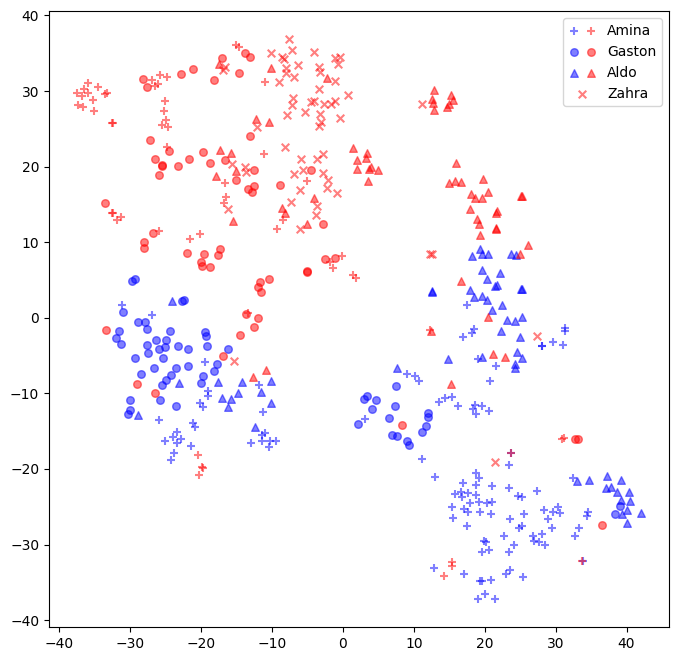

In [21]:
fig, ax = plt.subplots(1,1, figsize=(8,8))

markers = ['+', 'o', '^']
handles = []

for i, marker in enumerate(markers):
    idx1 = np.arange(i, 240 + 1, 4)
    idx2 = np.arange(240 + i, 480, 4)

    p1 = ax.scatter(et[idx1,0], et[idx1,1], s=30, marker=marker, c='b', alpha=0.5)
    p2 = ax.scatter(et[idx2,0], et[idx2,1], s=30, marker=marker, c='r', alpha=0.5)
    handles.append((p1,p2))

# do Amina's extra
marker = markers[0]
idx1 = np.arange(3, 240 + 1, 4)
ax.scatter(et[idx1,0], et[idx1,1], s=30, marker=marker, c='b', alpha=0.5)

# do Zahra
marker = 'x'
idx2 = np.arange(240 + 3, 480, 4)
p3 = ax.scatter(et[idx2,0], et[idx2,1], s=30, marker=marker, c='r', alpha=0.5)
handles.append((p3,))

labels = ['Amina', 'Gaston', 'Aldo', 'Zahra']
ax.legend(
    handles, labels,
    handler_map={tuple: HandlerTuple(ndivide=None)}
)

plt.show()

In [26]:
records[21]

{'0': {'event': {'Amina': 'Go to a coffee shop',
   'Gaston': 'Go to a coffee shop',
   'Aldo': 'Go to a coffee shop',
   'Zahra': 'Go to a coffee shop'},
  'transcript': [['Amina Osei',
    "Alright, everyone, let's dive into drafting the agenda for our community meeting. We've got some fantastic ideas from our last meetup—Gaston, your storytelling rooted in Luxembourgish folklore, and Aldo, your soundscapes inspired by local forests. Zahra, your input on incorporating nature-based activities was spot on. I'll make sure these elements are highlighted, and once I've drafted it, I'll circulate it for your feedback. Let's ensure it truly reflects our commitment to cultural heritage and sustainability."],
   ['Gaston Schneider',
    "Thanks, Amina. I'm really excited about weaving Luxembourgish folklore into our storytelling. I think we can draw some intriguing parallels between these tales and comic book narratives, which could add a unique layer to our event. Maybe we could create a seg